# CS 7641 Homework 1 - Fall 2020



Refs: 
- https://www.kaggle.com/cdabakoglu/heart-disease-classifications-machine-learning
- https://www.kaggle.com/arunmohan003/pruning-decision-trees
- https://www.studocu.com/da/document/danmarks-tekniske-universitet/introduktion-til-machine-learning-og-data-mining/obligatoriske-lektier/part-one-data-types-features-and-visualization/3113772/view
- https://github.com/JYORAM9/Abalone-Dataset/blob/master/RandomAbalone.ipynb

In [49]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn import tree, svm, datasets, metrics
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split,StratifiedKFold, StratifiedShuffleSplit, cross_validate, GridSearchCV
from sklearn.metrics import roc_curve, auc, accuracy_score, confusion_matrix, classification_report, roc_auc_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler
from sklearn.pipeline import Pipeline
from utilities import plot_2d_data, plot_2d_classifier, plot_confusionmatrix
from utilities import learning_curve_model, validation_curve_model, plot_grid_search
from scipy import stats
import seaborn as sns
import os

from utilities import get_colors
cm = get_colors(colormap='RdBu', n_colors=2)

## Loading Datasets

In [50]:
data = pd.read_csv("./data/abalone.csv")
data.head()

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


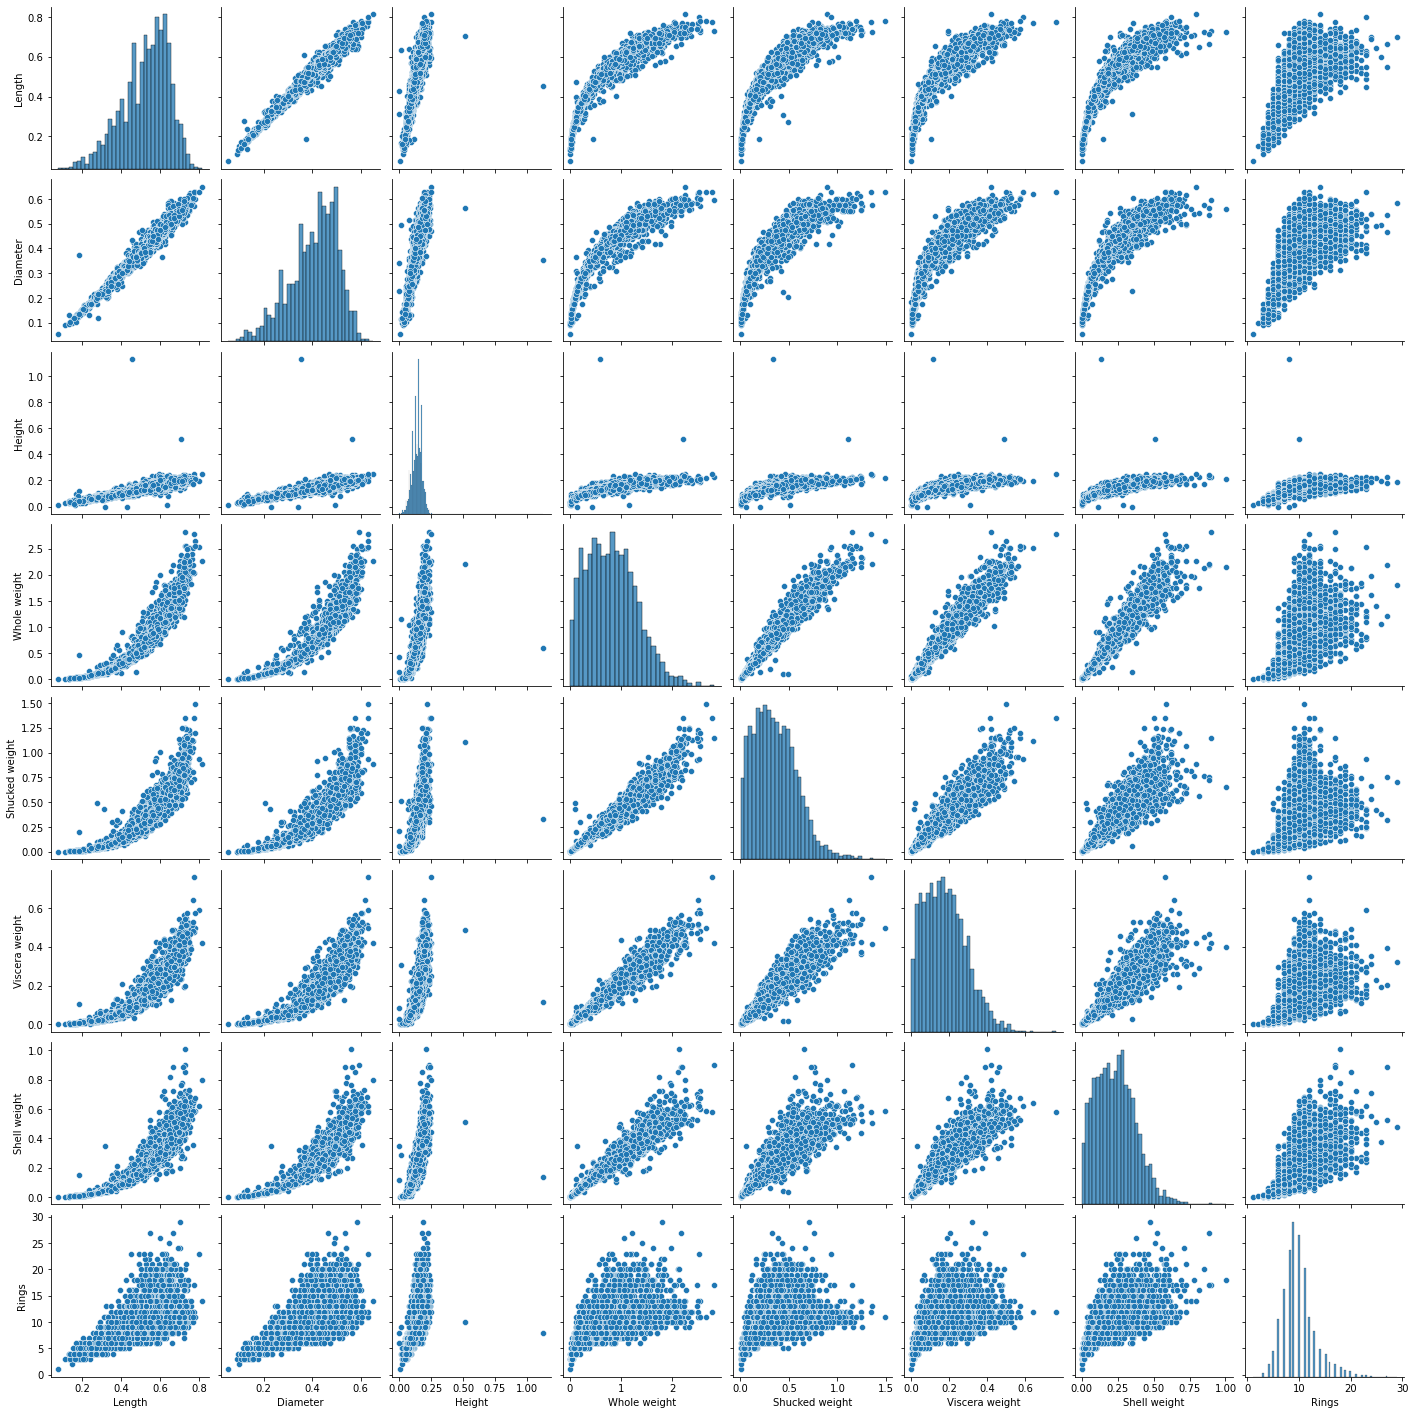

In [51]:
sns.pairplot(data)

In [52]:
def ringCategorization(ring):
    if ring < 9: return '1'
    if 9 <= ring < 15: return '2'
    if 15 <= ring < 21: return '3'
    else: return '4'

In [53]:
data = data.apply(LabelEncoder().fit_transform)
data['Volume']= data['Length'] * data['Diameter'] * data['Height']
# data['RingCat'] = data['Rings'].map(ringCategorization)
data.head(10)

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Volume
0,2,66,56,18,715,417,199,263,14,66528
1,2,45,36,17,285,178,94,113,6,27540
2,0,81,67,26,962,480,280,374,8,141102
3,2,63,56,24,718,400,225,273,9,84672
4,1,41,34,15,253,159,76,87,6,20910
5,1,60,43,18,463,254,152,207,7,46440
6,0,81,66,29,1109,441,280,592,19,155034
7,0,84,68,24,1097,552,296,462,15,137088
8,2,70,57,24,706,402,222,293,8,95760
9,0,85,71,29,1301,593,299,572,18,175015


- Sex - indicates sex of the abalone. M for male, F for female, and I for infant.
- Length - the length of the abalone in millimeters.
- Diameter - the diameter of the abalone in millimeters.
- Height - the height of the abalone in millimeters.
- Whole weight - the weight in grams of the whole abalone after capture.
- Shuckled weight - the weight of the abalone meat.
- Viscera weight - the weight in grams of the guts/intestines after the abalone has been bleeding.
- Shell weight - the weight in grams of the dried shell. The shell is porous and can carry a lot of water if not dried.
- Rings - the number of rings through the abalone shell. The age is equal to the number of rings plus 1.5

In [54]:
data.shape

(4177, 10)

In [55]:
correlation = data.corr()
correlation

,Sex,Length,Diameter,Height,Whole weight,Shucked weight,Viscera weight,Shell weight,Rings,Volume
Sex,1.000000,-0.036006,-0.038846,-0.040559,-0.026480,-0.009979,-0.035252,-0.035159,-0.034546,-0.036508
Length,-0.036006,1.000000,0.986815,0.898495,0.945616,0.923686,0.914853,0.925637,0.556666,0.917003
Diameter,-0.038846,0.986815,1.000000,0.904767,0.946053,0.919422,0.911692,0.932714,0.574718,0.922002
Height,-0.040559,0.898495,0.904767,1.000000,0.900422,0.855481,0.874504,0.906738,0.608239,0.916186
Whole weight,-0.026480,0.945616,0.946053,0.900422,1.000000,0.973950,0.966996,0.966973,0.554945,0.956093
Shucked weight,-0.009979,0.923686,0.919422,0.855481,0.973950,1.000000,0.940029,0.909816,0.442772,0.931489
Viscera weight,-0.035252,0.914853,0.911692,0.874504,0.966996,0.940029,1.000000,0.926469,0.513213,0.942232
Shell weight,-0.035159,0.925637,0.932714,0.906738,0.966973,0.909816,0.926469,1.000000,0.630742,0.947081
Rings,-0.034546,0.556666,0.574718,0.608239,0.554945,0.442772,0.513213,0.630742,1.000000,0.538010
Volume,-0.036508,0.917003,0.922002,0.916186,0.956093,0.931489,0.942232,0.947081,0.538010,1.000000


<AxesSubplot:>

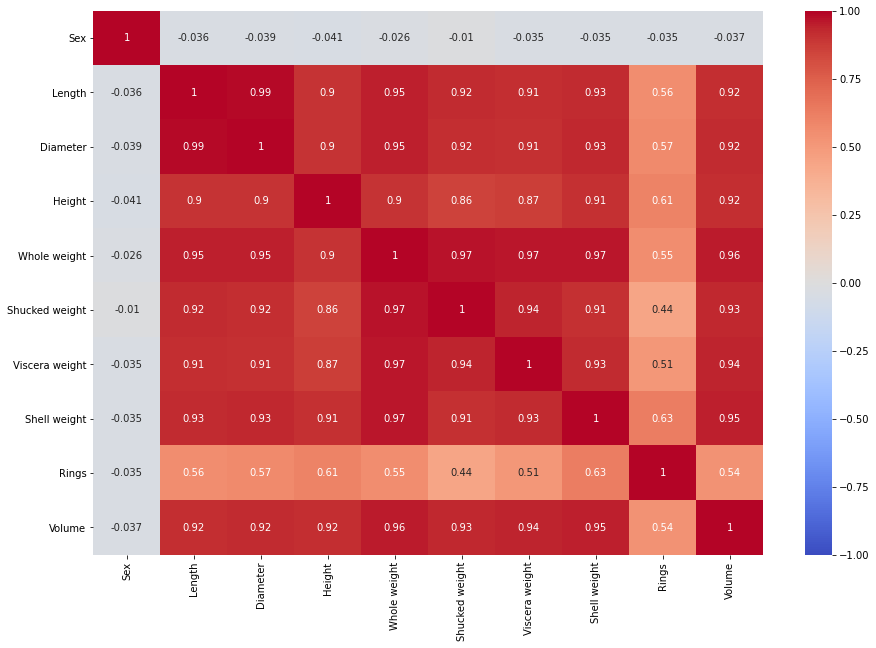

In [56]:
plt.figure(figsize=(15,10))
sns.heatmap(correlation, annot=True, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm')

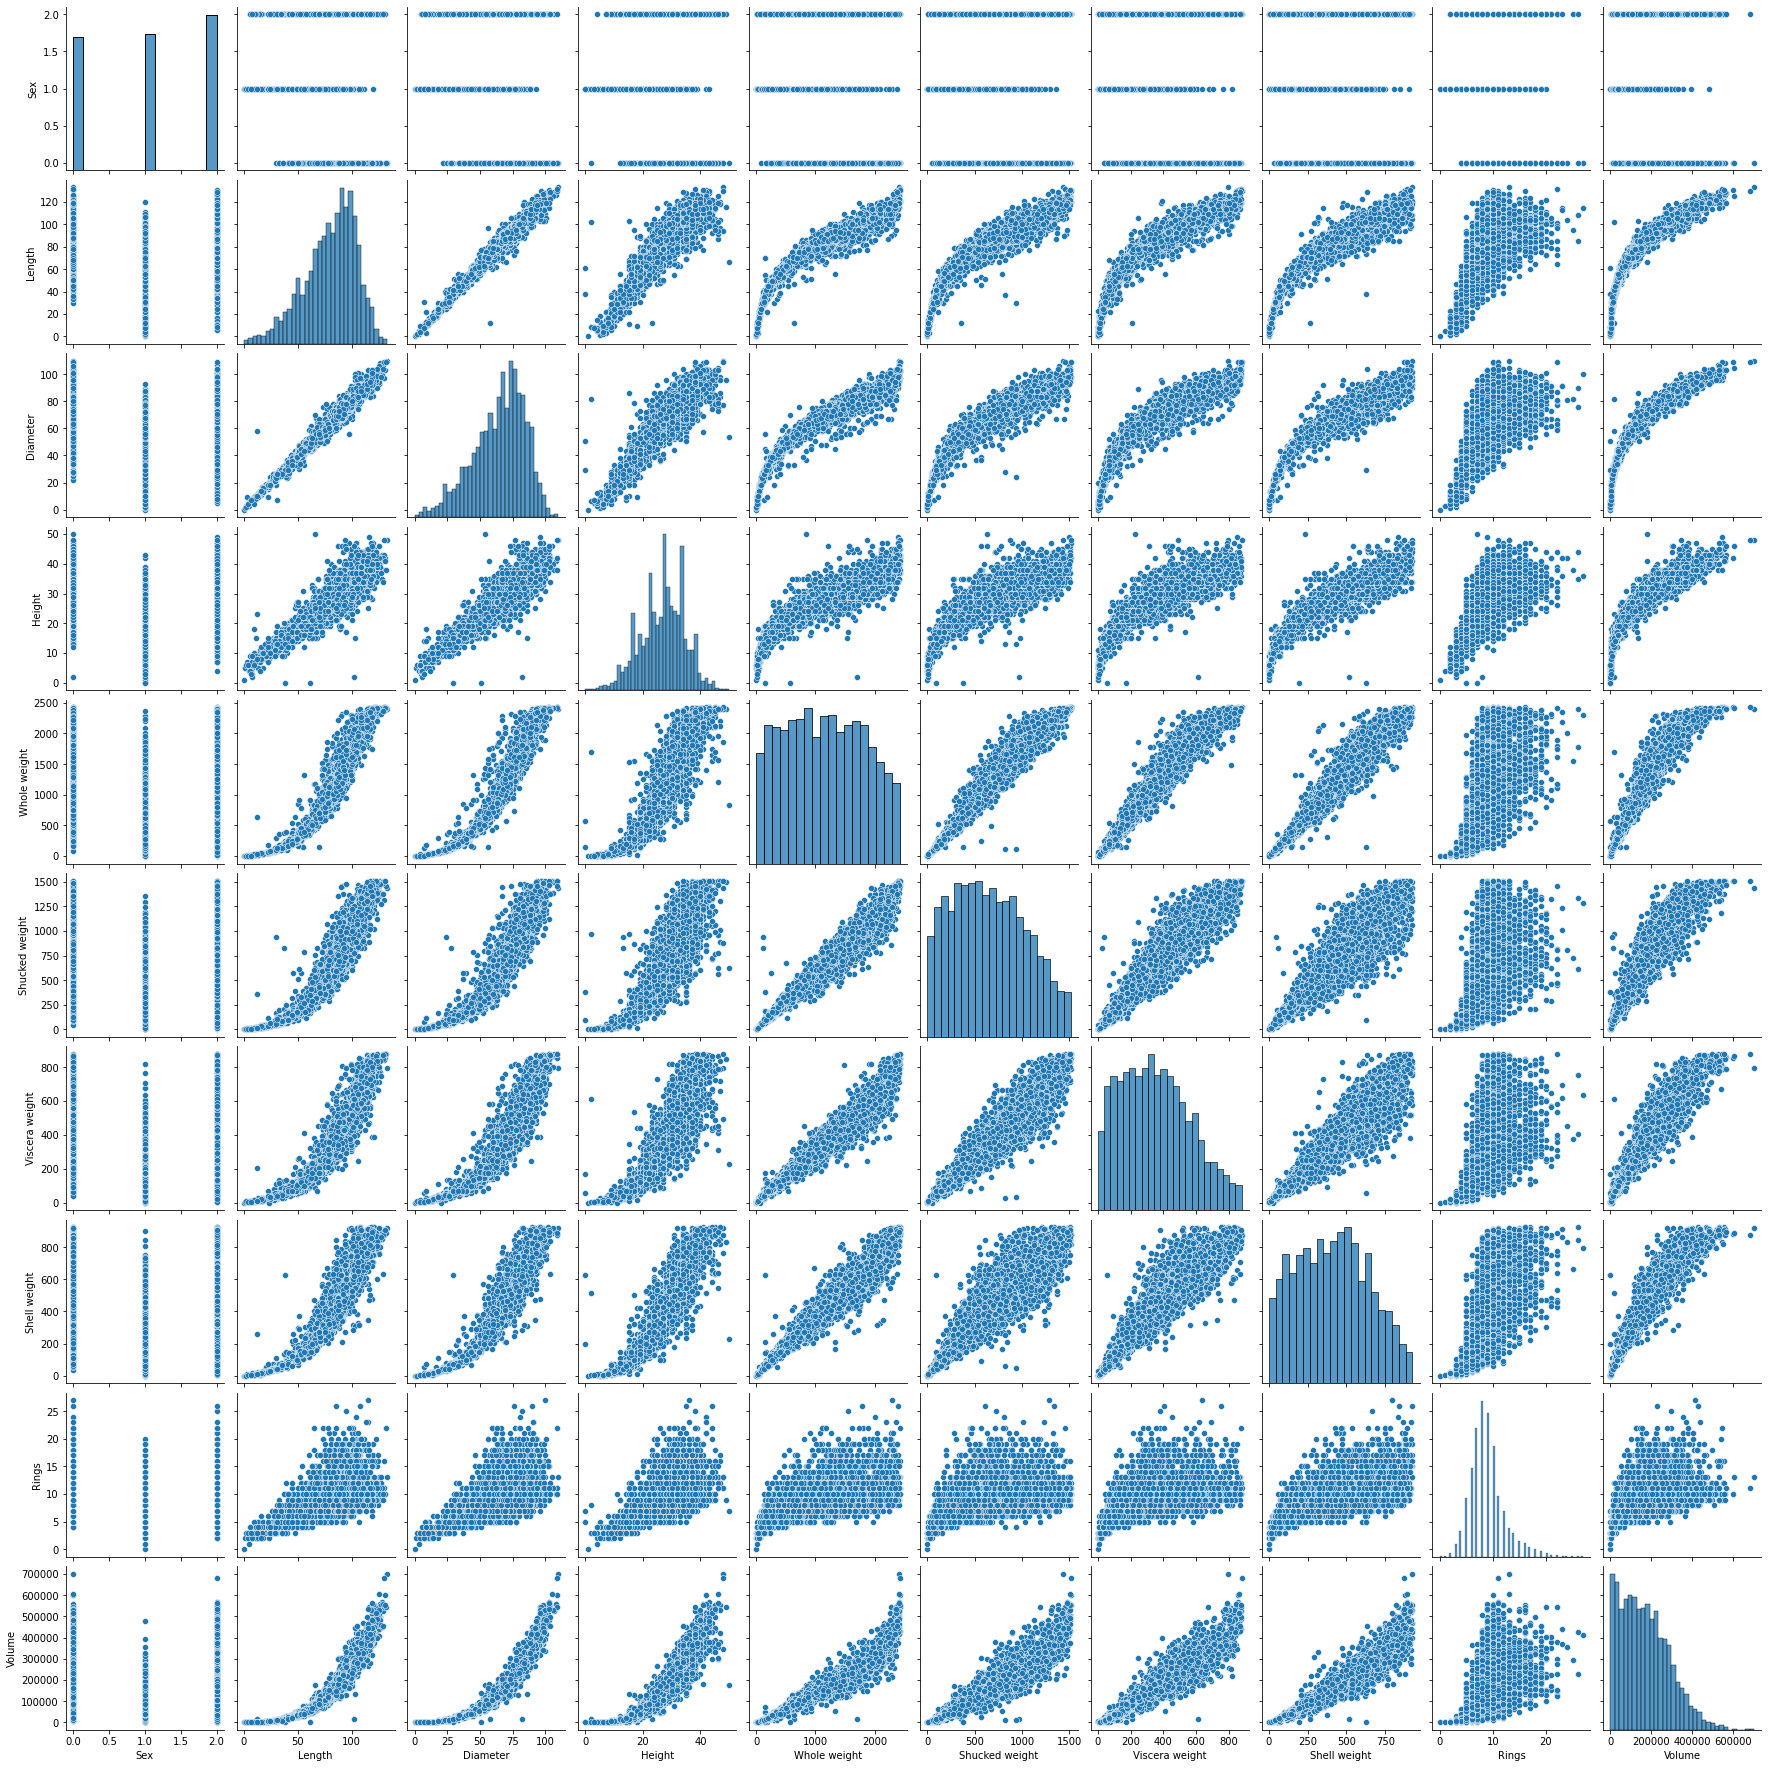

In [57]:
sns.pairplot(data)

In [58]:
data_X = data.drop(columns = ['Rings', 'Height', 'Length', 'Diameter'], axis=1)/256
data_y = data['Rings']

data_X = (data_X - np.min(data_X)) / (np.max(data_X) - np.min(data_X)).values

train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.2, random_state=100)

In [59]:
# helper function
def plot_confusionmatrix(y_train_pred,y_train,dom):
    print(f'{dom} Confusion matrix')
    cf = confusion_matrix(y_train_pred,y_train)
    sns.heatmap(cf,annot=True,yticklabels=classes
               ,xticklabels=classes,cmap='Blues', fmt='g')
    plt.tight_layout()
    plt.show()

## Decision Tree

In [60]:
# https://scikit-learn.org/stable/modules/tree.html
# https://deepstat.tistory.com/44
# https://jcabelloc.github.io/machine%20learning/2019/02/27/classification-task.html

dtc = tree.DecisionTreeClassifier(random_state=100)
dtc.fit(train_X, train_y)
predict_y_train = dtc.predict(train_X)
predict_y = dtc.predict(test_X)
print(f"Training accuracy score: {100* accuracy_score(train_y, predict_y_train)}%")
print(f"Testing accuracy Score: {100* accuracy_score(test_y, predict_y)}%")


Training accuracy score: 100.0%
Testing accuracy Score: 22.00956937799043%


### Decision Tree with Pre-prunning

In [61]:
params = {'max_depth': [2,4,6,8,10,12],
         'min_samples_split': [2,3,4],
         'min_samples_leaf': [1,2]}

dtc = tree.DecisionTreeClassifier()
gcv = GridSearchCV(estimator=dtc,param_grid=params)
gcv.fit(train_X,train_y)

/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_leaf': [1, 2],
                         'min_samples_split': [2, 3, 4]})

In [62]:
model = gcv.best_estimator_
model.fit(train_X,train_y)
train_prediction_y = model.predict(train_X)
test_prediction_y = model.predict(test_X)

print(f'Train score {accuracy_score(train_prediction_y,train_y)}')
print(f'Test score {accuracy_score(test_prediction_y,test_y)}')

Train score 0.3388207123615684
Test score 0.26435406698564595


### Decision Tree - post Pruning

In [63]:
path = dtc.cost_complexity_pruning_path(train_X, train_y)
ccp_alphas, impurities = path.ccp_alphas, path.impurities
print(ccp_alphas)

[0.         0.00019954 0.00019954 0.00019954 0.00019954 0.00019954
 0.00019954 0.00022448 0.00022448 0.00022448 0.00022448 0.00022448
 0.00022448 0.00022448 0.00022448 0.00022448 0.00022448 0.00022448
 0.00022448 0.00022448 0.00022448 0.00022448 0.00022448 0.00023945
 0.00023945 0.00023945 0.00023945 0.00023945 0.00023945 0.00023945
 0.00023945 0.00023945 0.00023945 0.00024319 0.00024943 0.00024943
 0.00024943 0.00024943 0.00024943 0.00024943 0.00024943 0.00024943
 0.00024943 0.00024943 0.00025441 0.00025441 0.00025655 0.00025655
 0.00025655 0.00025655 0.00025655 0.00025655 0.00025655 0.00025655
 0.00025655 0.00025655 0.00025655 0.0002585  0.0002594  0.0002619
 0.0002619  0.0002619  0.0002619  0.0002619  0.00026605 0.00026605
 0.00026605 0.00026605 0.00026605 0.00026605 0.00026605 0.00026605
 0.00026724 0.00026938 0.00026938 0.00026938 0.00027437 0.00027437
 0.00027793 0.0002806  0.00028171 0.00028933 0.00028944 0.00029599
 0.00029931 0.00029931 0.00029931 0.00029931 0.00029931 0.00029

In [64]:
# For each alpha we will append our model to a list
dtc_list = []
for ccp_alpha in ccp_alphas:
    dtc = tree.DecisionTreeClassifier(random_state=0, ccp_alpha=ccp_alpha)
    dtc.fit(train_X, train_y)
    dtc_list.append(dtc)

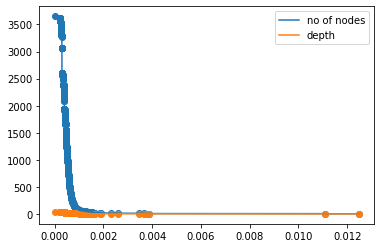

In [65]:
dtc_list = dtc_list[:-1]
ccp_alphas = ccp_alphas[:-1]
node_counts = [dtc.tree_.node_count for dtc in dtc_list]
depth = [dtc.tree_.max_depth for dtc in dtc_list]
plt.scatter(ccp_alphas,node_counts)
plt.scatter(ccp_alphas,depth)
plt.plot(ccp_alphas,node_counts,label='no of nodes',drawstyle="steps-post")
plt.plot(ccp_alphas,depth,label='depth',drawstyle="steps-post")
plt.legend()
plt.show()

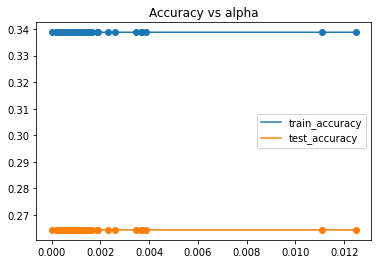

In [66]:
train_acc = []
test_acc = []
for dtc in dtc_list:
    y_train_pred = dtc.predict(train_X)
    y_test_pred = dtc.predict(test_X)
    train_acc.append(accuracy_score(train_prediction_y,train_y))
    test_acc.append(accuracy_score(test_prediction_y,test_y))

plt.scatter(ccp_alphas,train_acc)
plt.scatter(ccp_alphas,test_acc)
plt.plot(ccp_alphas,train_acc,label='train_accuracy',drawstyle="steps-post")
plt.plot(ccp_alphas,test_acc,label='test_accuracy',drawstyle="steps-post")
plt.legend()
plt.title('Accuracy vs alpha')
plt.show()

In [67]:
clf = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.002)
clf.fit(train_X,train_y)
y_train_pred = clf.predict(train_X)
y_test_pred = clf.predict(test_X)

print(f'Train score {accuracy_score(y_train_pred,train_y)}')
print(f'Test score {accuracy_score(y_test_pred,test_y)}')

Train score 0.26818317868901526
Test score 0.2619617224880383


In [68]:
 #Computing PCA projection
clf = tree.DecisionTreeClassifier(random_state=0,ccp_alpha=0.002)
pca = PCA(n_components=6)
pca_train_X= pca.fit(train_X).transform(train_X)
pca_test_X = pca.transform(test_X)
clf.fit(pca_train_X,train_y)
pred_train_y = clf.predict(pca_train_X)
pred_test_y = clf.predict(pca_test_X)

print(f'Train score {accuracy_score(pred_train_y,train_y)}')
print(f'Test score {accuracy_score(pred_test_y,test_y)}')

Train score 0.27746183777312183
Test score 0.27751196172248804


## Neural Network

In [69]:
model = MLPClassifier(alpha=1e-5, hidden_layer_sizes=(5,), solver='lbfgs', max_iter=5000, random_state=18)
model.fit(train_X, train_y)

MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5,), max_iter=5000,
              random_state=18, solver='lbfgs')

In [70]:
predicted = model.predict(test_X)
print("Classification Report:\n %s:" % (metrics.classification_report(test_y, predicted)))

Classification Report:
               precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.50      0.25      0.33         4
           3       0.53      0.67      0.59        15
           4       0.40      0.32      0.36        25
           5       0.28      0.36      0.31        44
           6       0.39      0.46      0.42        79
           7       0.33      0.38      0.35       108
           8       0.32      0.40      0.36       146
           9       0.24      0.34      0.28       127
          10       0.33      0.26      0.29       108
          11       0.18      0.04      0.07        46
          12       0.14      0.20      0.16        40
          13       0.00      0.00      0.00        23
          14       0.00      0.00      0.00        25
          15       0.33      0.07      0.12        14
          16       0.00      0.00      0.00        10
          17       0.00      0.00      0.00         3
   

/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [71]:
mlp = MLPClassifier(max_iter=5000, random_state=18)
param_list = {"hidden_layer_sizes": [(1,),(5,),(10,)], "solver": ["lbfgs", "sgd", "adam"], "alpha": [0.00001, 0.00005,0.0005]}

gcv = GridSearchCV(estimator=mlp, param_grid=param_list)
gcv.fit(train_X, train_y)

/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:471: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(estimator=MLPClassifier(max_iter=5000, random_state=18),
             param_grid={'alpha': [1e-05, 5e-05, 0.0005],
                         'hidden_layer_sizes': [(1,), (5,), (10,)],
                         'solver': ['lbfgs', 'sgd', 'adam']})

In [72]:
print(classification_report(gcv.best_estimator_.predict(test_X), test_y))
print('Best parameters found:\n', gcv.best_params_, gcv.best_score_)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.25      0.50      0.33         2
           3       0.60      0.50      0.55        18
           4       0.32      0.36      0.34        22
           5       0.36      0.27      0.31        60
           6       0.46      0.41      0.43        87
           7       0.39      0.33      0.35       129
           8       0.40      0.32      0.35       182
           9       0.35      0.25      0.29       174
          10       0.25      0.33      0.28        83
          11       0.02      0.10      0.04        10
          12       0.20      0.13      0.16        63
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.07      0.33      0.12         3
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       0.00    

/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [73]:
# All results
means = gcv.cv_results_['mean_test_score']
stds = gcv.cv_results_['std_test_score']
for mean, std, params in zip(means, stds, gcv.cv_results_['params']):
    print("%0.3f (+/-%0.03f) for %r" % (mean, std * 2, params))

0.258 (+/-0.021) for {'alpha': 1e-05, 'hidden_layer_sizes': (1,), 'solver': 'lbfgs'}
0.252 (+/-0.045) for {'alpha': 1e-05, 'hidden_layer_sizes': (1,), 'solver': 'sgd'}
0.269 (+/-0.034) for {'alpha': 1e-05, 'hidden_layer_sizes': (1,), 'solver': 'adam'}
0.278 (+/-0.032) for {'alpha': 1e-05, 'hidden_layer_sizes': (5,), 'solver': 'lbfgs'}
0.261 (+/-0.059) for {'alpha': 1e-05, 'hidden_layer_sizes': (5,), 'solver': 'sgd'}
0.276 (+/-0.042) for {'alpha': 1e-05, 'hidden_layer_sizes': (5,), 'solver': 'adam'}
0.274 (+/-0.026) for {'alpha': 1e-05, 'hidden_layer_sizes': (10,), 'solver': 'lbfgs'}
0.267 (+/-0.048) for {'alpha': 1e-05, 'hidden_layer_sizes': (10,), 'solver': 'sgd'}
0.275 (+/-0.044) for {'alpha': 1e-05, 'hidden_layer_sizes': (10,), 'solver': 'adam'}
0.259 (+/-0.022) for {'alpha': 5e-05, 'hidden_layer_sizes': (1,), 'solver': 'lbfgs'}
0.252 (+/-0.045) for {'alpha': 5e-05, 'hidden_layer_sizes': (1,), 'solver': 'sgd'}
0.269 (+/-0.034) for {'alpha': 5e-05, 'hidden_layer_sizes': (1,), 'solver

## Boosting

In [74]:
n_learning_rate_steps, n_folds = 10, 10
learning_rates = np.linspace(0.1, 1.0, num=n_learning_rate_steps)
splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)
trn_err = np.zeros((n_learning_rate_steps, n_folds))
val_err = np.zeros((n_learning_rate_steps, n_folds))
stump = DecisionTreeClassifier(max_depth=1, random_state = 100)
 
for i, rate in enumerate(learning_rates):
    for j, (trn, val) in enumerate(splitter.split(train_X, train_y)):
        model = AdaBoostClassifier(algorithm='SAMME', base_estimator=stump, 
                                   n_estimators=10, learning_rate=rate)
        model.fit(train_X.values[trn, :], train_y.values[trn])
        trn_err[i, j] = 1 - accuracy_score(train_y.values[trn], model.predict(train_X.values[trn, :]))
        val_err[i, j] = 1 - accuracy_score(train_y.values[val], model.predict(train_X.values[val, :]))
trn_err = np.mean(trn_err, axis=1)
val_err = np.mean(val_err, axis=1)
print(f'Training Error {trn_err}, Value Error {val_err}')

/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("

Training Error [0.78269944 0.78070426 0.78798734 0.78329834 0.77787719 0.78100399
 0.79636849 0.78472796 0.78482791 0.78163608], Value Error [0.78449638 0.78359371 0.78479757 0.79197784 0.7767191  0.78927429
 0.80634731 0.79198409 0.78629011 0.78778532]


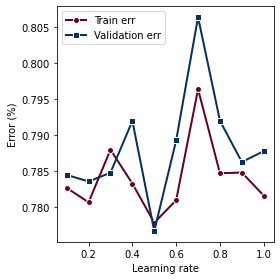

In [75]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.plot(learning_rates, trn_err, marker='o', c=cm[0], markeredgecolor='w', linewidth=2)
ax.plot(learning_rates, val_err, marker='s', c=cm[1], markeredgecolor='w', linewidth=2)
ax.legend(['Train err', 'Validation err'])
ax.set_xlabel('Learning rate')
ax.set_ylabel('Error (%)')

fig.tight_layout()

In [76]:
n_estimator_steps, n_folds = 2, 10
number_of_stumps = np.arange(2, 40, n_estimator_steps)
splitter = StratifiedKFold(n_splits=n_folds, shuffle=True)

trn_err = np.zeros((len(number_of_stumps), n_folds))
val_err = np.zeros((len(number_of_stumps), n_folds))

stump = DecisionTreeClassifier(max_depth=1)
for i, n_stumps in enumerate(number_of_stumps):
    for j, (trn, val) in enumerate(splitter.split(train_X, train_y)):
        model = AdaBoostClassifier(algorithm='SAMME', base_estimator=stump,
                                   n_estimators=n_stumps, learning_rate=1.0)
        model.fit(train_X.values[trn, :], train_y.values[trn])

        trn_err[i, j] = 1 - accuracy_score(train_y.values[trn], 
                                           model.predict(train_X.values[trn, :]))
        val_err[i, j] = 1 - accuracy_score(train_y.values[val], 
                                           model.predict(train_X.values[val, :]))

trn_err = np.mean(trn_err, axis=1)
val_err = np.mean(val_err, axis=1)

/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("The least populated class in y has only %d"
/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=10.
  warnings.warn(("

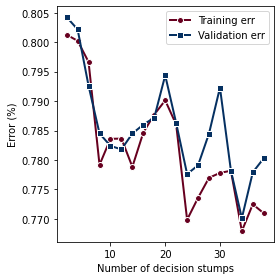

In [77]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(4, 4))

ax.plot(number_of_stumps, trn_err, marker='o', c=cm[0], markeredgecolor='w', linewidth=2)
ax.plot(number_of_stumps, val_err, marker='s', c=cm[1], markeredgecolor='w', linewidth=2)
ax.legend(['Training err', 'Validation err'])
ax.set_xlabel('Number of decision stumps')
ax.set_ylabel('Error (%)')

fig.tight_layout()

In [78]:
shallow_tree = DecisionTreeClassifier(max_depth=1)
ensemble = AdaBoostClassifier(base_estimator=shallow_tree, 
                                  n_estimators=22, learning_rate=0.7)
ensemble.fit(train_X, train_y)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.7, n_estimators=22)

In [79]:
ypred = ensemble.predict(test_X)
acc = accuracy_score(test_y, ypred)
print(f'Accuracy: {acc*100:.2f}%')

Accuracy: 23.80%


## SVM

In [80]:
model = svm.SVC(kernel='rbf', C=30, gamma='auto')
model.fit(train_X, train_y)
print(f'{model.score(test_X, test_y)*100:.2f}%')

27.99%


In [81]:
from sklearn.model_selection import cross_val_score

In [34]:
from sklearn.model_selection import GridSearchCV
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import f1_score, make_scorer, classification_report

# https://stackoverflow.com/questions/12632992/gridsearch-for-an-estimator-inside-a-onevsrestclassifier

# model_OVRC = OneVsRestClassifier(svm.LinearSVC(class_weight='balanced', max_iter=10000))
# svm_model = svm.LinearSVC(class_weight='balanced', max_iter=100000)
svm_model = svm.SVC()

parameters = {'C':(0.1, 0.5, 1, 2, 5, 10, 20, 40, 100), 
          "gamma":(0.001, 0.01, 0.1, 0.25, 0.5, 0.75, 1), 
          "kernel":('linear', 'poly', 'rbf')
         }

model = GridSearchCV(svm_model, parameters, cv=5)

model.fit(train_X, train_y)
model_predict = model.predict(test_X)

print(classification_report(test_y, model_predict))


/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"


              precision    recall  f1-score   support

           1       0.00      0.00      0.00         1
           2       0.00      0.00      0.00         4
           3       0.00      0.00      0.00        15
           4       0.28      0.44      0.34        25
           5       0.29      0.32      0.30        44
           6       0.40      0.42      0.41        79
           7       0.34      0.33      0.33       108
           8       0.31      0.47      0.37       146
           9       0.23      0.43      0.30       127
          10       0.36      0.22      0.28       108
          11       0.00      0.00      0.00        46
          12       0.17      0.12      0.14        40
          13       0.00      0.00      0.00        23
          14       0.00      0.00      0.00        25
          15       0.00      0.00      0.00        14
          16       0.00      0.00      0.00        10
          17       0.00      0.00      0.00         3
          18       0.00    

/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## KNN

In [35]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix

In [36]:
KNN_Model = KNeighborsClassifier(n_neighbors=2).fit(train_X, train_y)

# https://stackoverflow.com/questions/52910061/implementing-roc-curves-for-k-nn-machine-learning-algorithm-using-python-and-sci

In [41]:
y_scores = KNN_Model.predict_proba(test_X)

#macro_roc_auc_ovo = roc_auc_score(test_y, y_scores, multi_class="ovo", average="macro")
#weighted_roc_auc_ovo = roc_auc_score(test_y, y_scores, multi_class="ovo", average="weighted")
#macro_roc_auc_ovr = roc_auc_score(test_y, y_scores, multi_class="ovr", average="macro")
#weighted_roc_auc_ovr = roc_auc_score(test_y, y_scores, multi_class="ovr", average="weighted")
#print("One-vs-One ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
#      "(weighted by prevalence)"
#      .format(macro_roc_auc_ovo, weighted_roc_auc_ovo))
#print("One-vs-Rest ROC AUC scores:\n{:.6f} (macro),\n{:.6f} "
#      "(weighted by prevalence)"
#      .format(macro_roc_auc_ovr, weighted_roc_auc_ovr))


In [42]:
print(f'2 NN Score: {KNN_Model.score(test_X, test_y)*100:.2f}%')

2 NN Score: 21.89%


In [46]:
# try to find best k value
scoreList = []

grid_params = { 'n_neighbors': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
                'weights': ['uniform', 'distance'],
                'metric': ['euclidean', 'manhattan','minkowski']
              }
gcv_KNN = GridSearchCV(KNeighborsClassifier(),grid_params, n_jobs=-1)
print(classification_report(gcv.best_estimator_.predict(test_X), test_y))
print('Best parameters found:\n', gcv.best_params_, gcv.best_score_)

              precision    recall  f1-score   support

           1       0.00      0.00      0.00         0
           2       0.25      0.50      0.33         2
           3       0.60      0.50      0.55        18
           4       0.32      0.36      0.34        22
           5       0.36      0.27      0.31        60
           6       0.46      0.41      0.43        87
           7       0.39      0.33      0.35       129
           8       0.40      0.32      0.35       182
           9       0.35      0.25      0.29       174
          10       0.25      0.33      0.28        83
          11       0.02      0.10      0.04        10
          12       0.20      0.13      0.16        63
          13       0.00      0.00      0.00         0
          14       0.00      0.00      0.00         0
          15       0.07      0.33      0.12         3
          16       0.00      0.00      0.00         0
          17       0.00      0.00      0.00         0
          18       0.00    

/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/worthylafollette/dev/venv/ml/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
plot_grid_search(gcv_KNN.grid_scores_, n_estimators, max_features, 'N Estimators', 'Max Features')

AttributeError: 'GridSearchCV' object has no attribute 'grid_scores_'

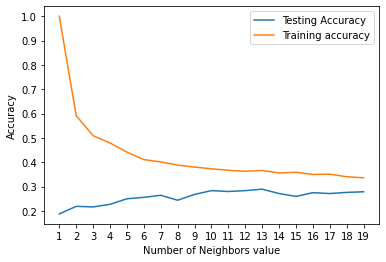

Maximum KNN Score is 28.95% at 13 neighbors


In [106]:
# try to find best k value
# https://ashutoshtripathi.com/2019/08/05/a-complete-guide-to-k-nearest-neighbors-algorithm-knn-using-python/
scoreList = []
neighbors = np.arange(1,20)
train_accuracy =np.empty(len(neighbors))
test_accuracy = np.empty(len(neighbors))
for i, k in enumerate(neighbors):
    knn2 = KNeighborsClassifier(n_neighbors = k)  # n_neighbors means k
    knn2.fit(train_X, train_y)
    # fpr, tpr, thresholds = metrics.roc_curve(test_y, knn2.predict_proba(test_X))
    # Calculate Area under the curve to display on the plot
    # auc = metrics.roc_auc_score(test_y,knn2.predict(test_X), multi_class='ovo')
    # Now, plot the computed values
    # plt.plot(fpr, tpr, label='%s ROC (area = %0.2f)' % (f'# Nodes: {i}', auc))
    #Compute accuracy on the training set 
    train_accuracy[i] = knn2.score(train_X, train_y) 
    #Compute accuracy on the test set 
    test_accuracy[i] = knn2.score(test_X, test_y) 
    # scoreList.append(knn2.score(test_X, test_y))
    # Custom settings for the plot 

# plt.plot([0, 1], [0, 1],'r--')
# plt.xlim([0.0, 1.0])
# plt.ylim([0.0, 1.05])
# plt.xlabel('1-Specificity(False Positive Rate)')
# plt.ylabel('Sensitivity(True Positive Rate)')
# plt.title('Receiver Operating Characteristic')
# plt.legend(loc="lower right")
# plt.show()   # Display

plt.plot(neighbors, test_accuracy, label='Testing Accuracy')
plt.plot(neighbors, train_accuracy, label='Training accuracy')
# plt.plot(neighbors, scoreList)
plt.xticks(neighbors)
plt.legend()
plt.xlabel("Number of Neighbors value")
plt.ylabel("Accuracy")
plt.show()

acc = max(test_accuracy)*100
key = np.argmax(test_accuracy) + 1
print(f'Maximum KNN Score is {acc:.2f}% at {key} neighbors')

In [ ]:
for i in range(1,20):
    knn2 = KNeighborsClassifier(n_neighbors = i)  # n_neighbors means k
    knn2.fit(train_X, train_y)
    scoreList.append(knn2.score(test_X, test_y))
    
plt.plot(range(1,20), scoreList)
plt.xticks(np.arange(1,20,1))
plt.xlabel("K value")
plt.ylabel("Score")
plt.show()

acc = max(scoreList)*100
print(f'Maximum KNN Score is {acc:.2f}%')